In [1]:
import os
import numpy as np
import dask.array as da
import dask
import matplotlib.pyplot as plt

dask.config.set(scheduler='threads')
# dask.config.set(scheduler='processes')
# dask.config.set(scheduler='synchronous')
%load_ext cython

In [2]:
%%cython --force

cimport cython
import numpy as np
cimport numpy as np

ctypedef np.int_t DTYPE_t

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
def merge_c(DTYPE_t[::1] x):
    out = np.zeros(len(x), dtype=int)
    cdef DTYPE_t[::1] out_view = out
    cdef int mid = (x.shape[0] - 1) // 2 + 1
    cdef int i = 0
    cdef int j = mid
    cdef int k = 0
    while i < mid and j < x.shape[0]:
        if x[i] < x[j]:
            out_view[k] = x[i]
            i += 1
        else:
            out_view[k] = x[j]
            j += 1
        k += 1

    while i < mid:
        out_view[k] = x[i]
        k += 1
        i += 1
    while j < x.shape[0]:
        out_view[k] = x[j]
        k += 1
        j += 1
    return out

In [3]:
def merge_chunks(chunks):
#     if len(chunks) == 1:
#         return tuple()
    return tuple(chunks[i] + chunks[i+1] for i in range(0, len(chunks)-1, 2))

def psort(x):
    chunks = x.chunks[0]
    x = x.map_blocks(np.sort)
    while len(chunks) >= 2:
#         print(x.compute())
        chunks = merge_chunks(chunks)
        x = x.rechunk((chunks,))
        x = x.map_blocks(merge_c, dtype=int)
    return x

In [9]:
N = 2**4
print(N)
tasks_per_core = 1
x = da.arange(N, chunks=N/(8*tasks_per_core))[::-1]
x = psort(x)
res = %timeit -o -n 1 -r 3 x.compute()

16
4.77 ms ± 1.87 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [7]:
res.all_runs

[0.2486845999956131]

## error
https://stackoverflow.com/questions/51912031/dask-with-cython-in-juypter-modulenotfounderror-no-module-named-cython-magic

In [ ]:
tasks_per_core = 1
scales = list(range(4, 31, 2))
ts_psort = []
ts_np = []
for scale in scales:
    N = 2**scale
    x = da.arange(N, chunks=N/(8*tasks_per_core))[::-1]
    x = psort(x)
    res = %timeit -o -n 1 -r 3 x.compute()
    avg = sum(res.all_runs) / len(res.all_runs)
    ts_psort.append(avg)
    
    x = np.arange(N)[::-1]
    res = %timeit -o -n 1 -r 3 np.sort(x)
    avg = sum(res.all_runs) / len(res.all_runs)
    ts_np.append(avg)

Text(0.5, 0, 'array size (2^n)')

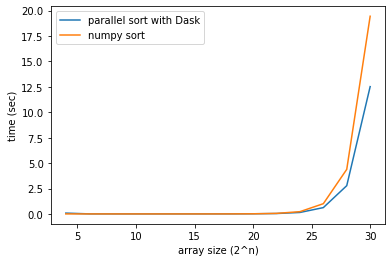

In [10]:
plt.plot(scales, ts_psort, label='parallel sort with Dask')
plt.plot(scales, ts_np, label='numpy sort')
plt.legend()
plt.ylabel('time (sec)')
plt.xlabel('array size (2^n)')